In [1]:
from unsloth import FastVisionModel
import torch

model, processor = FastVisionModel.from_pretrained(
    model_name="fl_lora",  # YOUR MODEL YOU USED FOR TRAINING
    load_in_4bit=True,  # Set to False for 16bit LoRA
    max_seq_length=4096
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


c:\Users\ryan\miniconda3\envs\unsloth\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


c:\Users\ryan\miniconda3\envs\unsloth\Lib\site-packages\unsloth_zoo\gradient_checkpointing.py:339: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.7.9: Fast Qwen2_5_Vl patching. Transformers: 4.53.3.
   \\   /|    NVIDIA GeForce RTX 4070 Laptop GPU. Num GPUs = 1. Max memory: 7.996 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,  # False if not finetuning vision layers
    finetune_language_layers=True,  # False if not finetuning language layers
    finetune_attention_modules=True,  # False if not finetuning attention layers
    finetune_mlp_modules=True,  # False if not finetuning MLP layers
    r=16,  # The larger, the higher the accuracy, but might overfit
    lora_alpha=16,  # Recommended alpha == r at least
    lora_dropout=0,
    bias="none",
    random_state=3407,
    use_rslora=False,  # We support rank stabilized LoRA
    loftq_config=None,  # And LoftQ
    target_modules="all-linear",  # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [9]:
from datasets import load_dataset

base_url = "../data_generation/dataset_s2_sm_disk/"
dataset = load_dataset(
    "arrow",
    data_files={
        "train": base_url + "train/data-00000-of-00001.arrow",
        "test": base_url + "test/data-00000-of-00001.arrow"
    },
    split="train"
)

c:\Users\ryan\miniconda3\envs\unsloth\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
instruction = "You are provided 1 or more views of a robot subsystem. Output the parts in the subsystem, as well as their spatial positions/orientations based on the first image's isometric reference frame, in the format of an array of JSON. Treat the center of the image as (0, 0, 0), and round all numbers to 2 or fewer decimal places. Example Output: " \
"[{\"name\": \"UChannel4H\", \"position\": [-0.0, -0.0, -6.46], \"rotation\": [180, 0, 0]}, {\"name\": \"UChannel1H\", \"position\": [-0.0, -84.0, 6.51], \"rotation\": [0.0, 0.0, -90.0]}]"

def conversation_template(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                *({"type": "image", "image": img.resize((512, 512))} for img in sample["images"])
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["label"]}]},
    ]
    return {"messages": conversation}

converted_dataset = [conversation_template(sample) for sample in dataset]

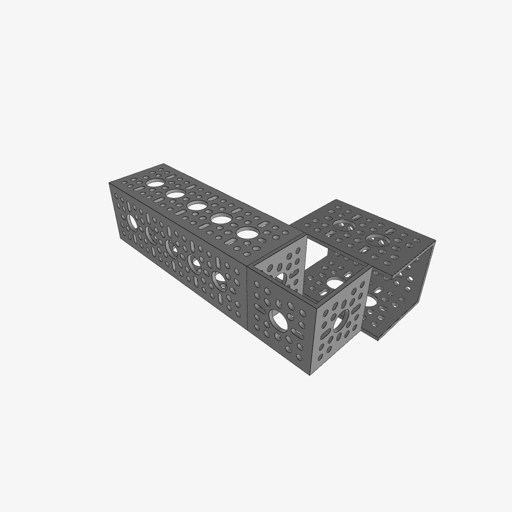

In [6]:
dataset[1]["images"][0].resize((512, 512))

In [55]:
dataset[1]["label"]

'[{"name": "UChannel2H", "position": [96.0, -0.0, -54.48], "rotation": [180, 0, 90]}, {"name": "UChannel1H", "position": [96.0, -0.0, 6.51], "rotation": [0.0, 0.0, 0.0]}, {"name": "UChannel5H", "position": [0.0, -0.0, 6.46], "rotation": [0.0, 0.0, 90.0]}]'

In [7]:
FastVisionModel.for_inference(model)

images = [img.resize((512, 512)) for img in dataset[1]["images"]]

messages = [
    {
        "role": "user",
        "content": [*({"type": "image"} for _ in images), {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    images,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.0,
    top_p=0.95,
    top_k=64
)

There are none.<|im_end|>


In [8]:
model.max_seq_length

4096

In [13]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)  # Enable for training!
torch._dynamo.config.cache_size_limit = 32

trainer = SFTTrainer(
    model=model,
    tokenizer=processor,
    data_collator=UnslothVisionDataCollator(model, processor),  # Must use!
    train_dataset=converted_dataset,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        # max_steps=30,
        num_train_epochs = 5, # Set this instead of max_steps for full training runs
        learning_rate=2e-4,
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",  # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        max_seq_length=4096,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [10]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4070 Laptop GPU. Max memory = 7.996 GB.
5.092 GB of memory reserved.


In [14]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 800 | Num Epochs = 5 | Total steps = 500
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,084,928 of 3,795,707,904 (1.08% trained)


Step,Training Loss
1,1.222400
2,1.306000
3,1.214700
4,1.176500
5,1.058500
6,0.882600
7,0.761900
8,0.647200
9,0.527300
10,0.392600


In [15]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

10660.9703 seconds used for training.
177.68 minutes used for training.
Peak reserved memory = 10.156 GB.
Peak reserved memory for training = 5.064 GB.
Peak reserved memory % of max memory = 127.014 %.
Peak reserved memory for training % of max memory = 63.332 %.


In [16]:
model.save_pretrained("fl_lora_s2")  # Local saving
processor.save_pretrained("fl_lora_s2")

[]

In [17]:
FastVisionModel.for_inference(model)

images = [img.resize((512, 512)) for img in dataset[1]["images"]]

messages = [
    {
        "role": "user",
        "content": [
            *({"type": "image"} for _ in images),
            {"type": "text", "text": instruction},
        ],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    images,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.0,
    top_p=0.95,
    top_k=64
)

[{"name": "UChannel3H", "position": [6.47, 0.0, 48.0], "rotation": [90, 90, 0]}, {"name": "UChannel4H", "position": [-0.0, -6.46, -0.0], "rotation": [90.0, 0.0, 0.0]}]<|im_end|>


In [4]:
basic_output = [{"name": "UChannel3H", "position": [6.47, 0.0, 48.0], "rotation": [90, 90, 0]}, {"name": "UChannel4H", "position": [-0.0, -6.46, -0.0], "rotation": [90.0, 0.0, 0.0]}]

In [2]:
import os
import trimesh
MODEL_DIR = "../data_generation/models_sm/"

def load_mesh(filepath):
    mesh = trimesh.load_mesh(filepath)
    mesh.apply_translation(-mesh.centroid)
    mesh.apply_scale(1000)
    return mesh

steps = [f for f in os.listdir(MODEL_DIR) if f.lower().endswith(".step")]
meshes = [load_mesh(os.path.join(MODEL_DIR, f)) for f in steps]

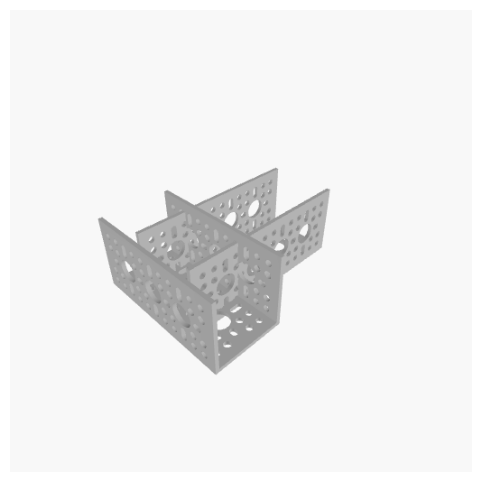

In [12]:
import pyrender
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

IMG_SIZE = 512
r = pyrender.OffscreenRenderer(viewport_width=IMG_SIZE, viewport_height=IMG_SIZE)


def random_grayscale_color(min_val=0.2, max_val=0.8, tint_strength=0.0):
    base = np.random.uniform(min_val, max_val)
    r = np.clip(base + np.random.uniform(-tint_strength, tint_strength), 0, 1)
    g = np.clip(base + np.random.uniform(-tint_strength, tint_strength), 0, 1)
    b = np.clip(base + np.random.uniform(-tint_strength, tint_strength), 0, 1)
    return np.array([r, g, b])


def look_at(v_e, v_t=np.array((0, 0, 0)), up=np.array((0, 1, 0))):
    forward = v_t - v_e
    forward /= np.linalg.norm(forward)
    up = np.array([1, 0, 0]) if abs(np.dot(forward, up)) > 0.999 else up

    right = np.cross(forward, up)
    right /= np.linalg.norm(right)

    up = np.cross(right, forward)

    rot = np.eye(4)
    rot[:3, 0] = right
    rot[:3, 1] = up
    rot[:3, 2] = -forward

    trans = np.eye(4)
    trans[:3, 3] = v_e

    pose = trans @ rot
    return pose


scene = pyrender.Scene(
    bg_color=np.append(random_grayscale_color(0.9, 0.975), 1.0),
    ambient_light=[0.3, 0.3, 0.3, 1.0],
)

cam_isod = 150

cam_pose = look_at(
    np.array([cam_isod, cam_isod, cam_isod], dtype=np.dtypes.Float64DType)
)
scene.add(pyrender.PerspectiveCamera(yfov=np.pi / 3.0), pose=cam_pose)

for xm, ym, zm in np.array(list(product((-1, 1), repeat=3))):
    light_pose = look_at(
        np.array(
            [cam_isod * xm, cam_isod * ym, cam_isod * zm], dtype=np.dtypes.Float64DType
        )
    )
    light = pyrender.DirectionalLight(intensity=2.5)
    scene.add(light, pose=light_pose)

for data in basic_output:
    i = steps.index(data["name"] + ".STEP")
    m = meshes[i].copy()

    T = np.eye(4)
    T[:3, :3] = R.from_euler("xyz", data["rotation"], degrees=True).as_matrix()
    T[:3, 3] = data["position"]

    m.apply_transform(T)
    scene.add(pyrender.Mesh.from_trimesh(m))

color, _ = r.render(scene)

plt.figure(figsize=(8, 6))
plt.axis("off")
plt.imshow(color)
plt.show()

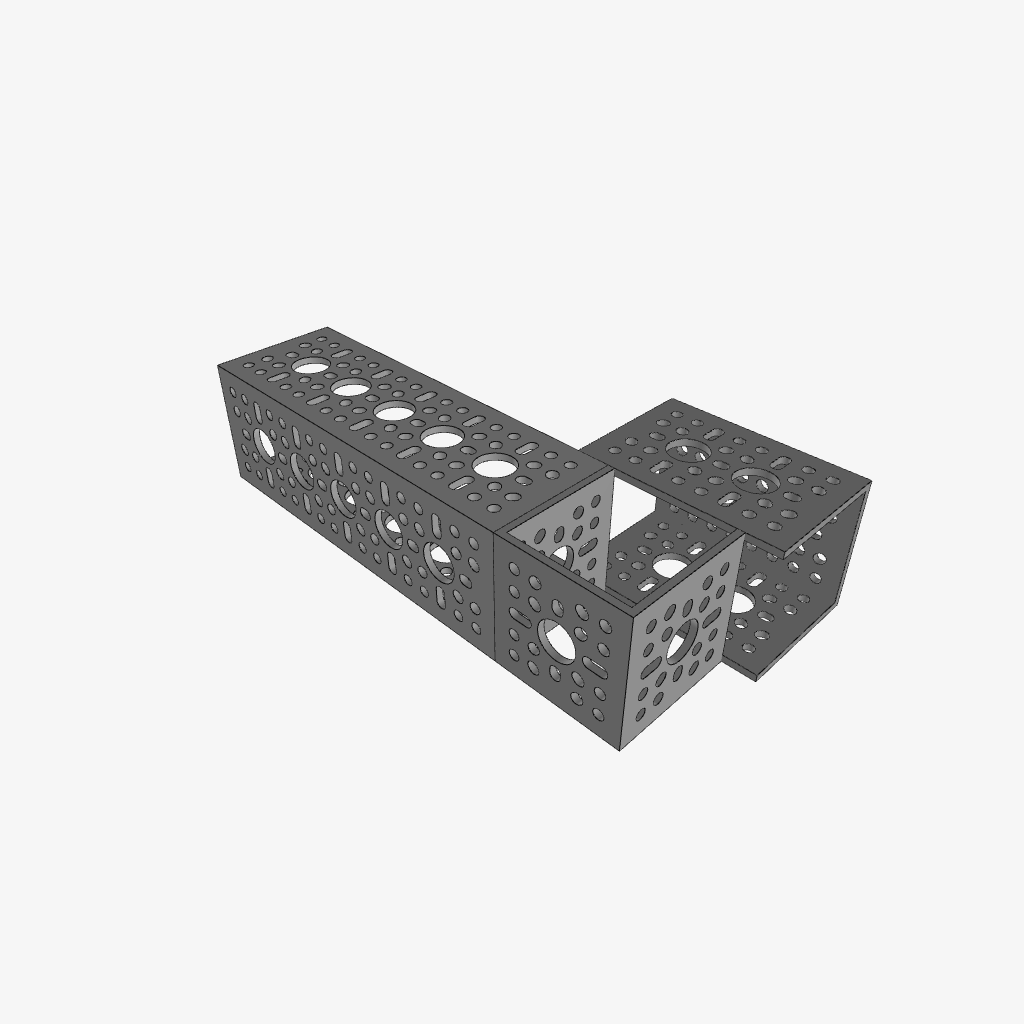

In [11]:
dataset[1]["images"][0]